# Analyzing Starbucks Stock with Time Series 

In [2]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os

import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Exploratory data analysis

In [5]:
df = pd.read_csv('./SBUX.US_D1.csv', 
                           skipfooter=1,  
                           header=0, 
                           index_col=0, engine='python')

In [6]:
df.tail()

,open,high,low,close,volume
datetime,,,,,
2024-01-03,93.70,94.24,93.06,93.24,4318676
2024-01-04,93.23,94.58,93.00,93.53,4019619
2024-01-05,93.54,93.58,92.48,93.00,5182516
2024-01-06,93.00,93.00,92.99,92.99,926082
2024-01-08,93.02,94.57,92.95,94.17,4403318


In [7]:
df.describe()

,open,high,low,close,volume
count,6585.000000,6585.000000,6585.000000,6585.000000,6.585000e+03
mean,51.685973,52.264513,51.099526,51.694847,5.804854e+06
std,27.010960,27.163089,26.842444,27.005190,4.669187e+06
min,7.520000,7.900000,7.060000,7.200000,3.000000e+02
25%,29.390000,29.880000,28.870000,29.410000,2.871792e+06
50%,48.840000,49.530000,48.310000,48.940000,4.697984e+06
75%,70.620000,71.240000,70.050000,70.600000,7.321931e+06
max,126.080000,126.320000,124.810000,126.060000,7.234445e+07


In [8]:
# setting date as index

df.index = pd.to_datetime(df.index)

In [9]:
df.index

DatetimeIndex(['1998-01-02', '1998-01-05', '1998-01-06', '1998-01-07',
               '1998-01-08', '1998-01-09', '1998-01-12', '1998-01-13',
               '1998-01-14', '1998-01-15',
               ...
               '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
               '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-06', '2024-01-08'],
              dtype='datetime64[ns]', name='datetime', length=6585, freq=None)

In [10]:
# checking for missing values to give a frequency to the time series

print('\nUnique dates in our data: ', len(df.index.unique()), 'Days')
our_date_range = df.index.max() - df.index.min()

print('Total days in our date range:', our_date_range.days, 'Days')


Unique dates in our data:  6585 Days
Total days in our date range: 9502 Days


In [11]:
# re-indexing

new_index = pd.date_range(df.index.min(), df.index.max())
print(new_index)

DatetimeIndex(['1998-01-02', '1998-01-03', '1998-01-04', '1998-01-05',
               '1998-01-06', '1998-01-07', '1998-01-08', '1998-01-09',
               '1998-01-10', '1998-01-11',
               ...
               '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
               '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06',
               '2024-01-07', '2024-01-08'],
              dtype='datetime64[ns]', length=9503, freq='D')


In [12]:
df_new = df.reindex(new_index)
df_new.bfill(inplace = True)

In [13]:
df_new.index

DatetimeIndex(['1998-01-02', '1998-01-03', '1998-01-04', '1998-01-05',
               '1998-01-06', '1998-01-07', '1998-01-08', '1998-01-09',
               '1998-01-10', '1998-01-11',
               ...
               '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
               '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06',
               '2024-01-07', '2024-01-08'],
              dtype='datetime64[ns]', length=9503, freq='D')

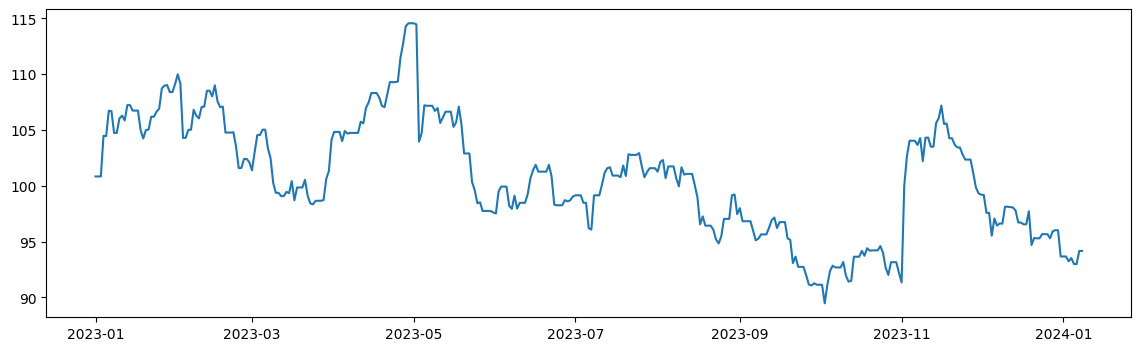

In [14]:
# selecting last year of data

df_new2 = df_new[['close']]['2023':]

fig, axes = plt.subplots(1,1, figsize=(14,4))
axes.plot(df_new2)

We have to understand the features of the time series and check if it is stationary or not. To do so, we create a helper function, which plots the raw data along with the ACF and PACF.

In [15]:
def plots(data, lags=None):

    plt.figure(figsize=(15,5))
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
        
    raw.plot(data)
    sm.graphics.tsaplots.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.graphics.tsaplots.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()

    plt.tight_layout()


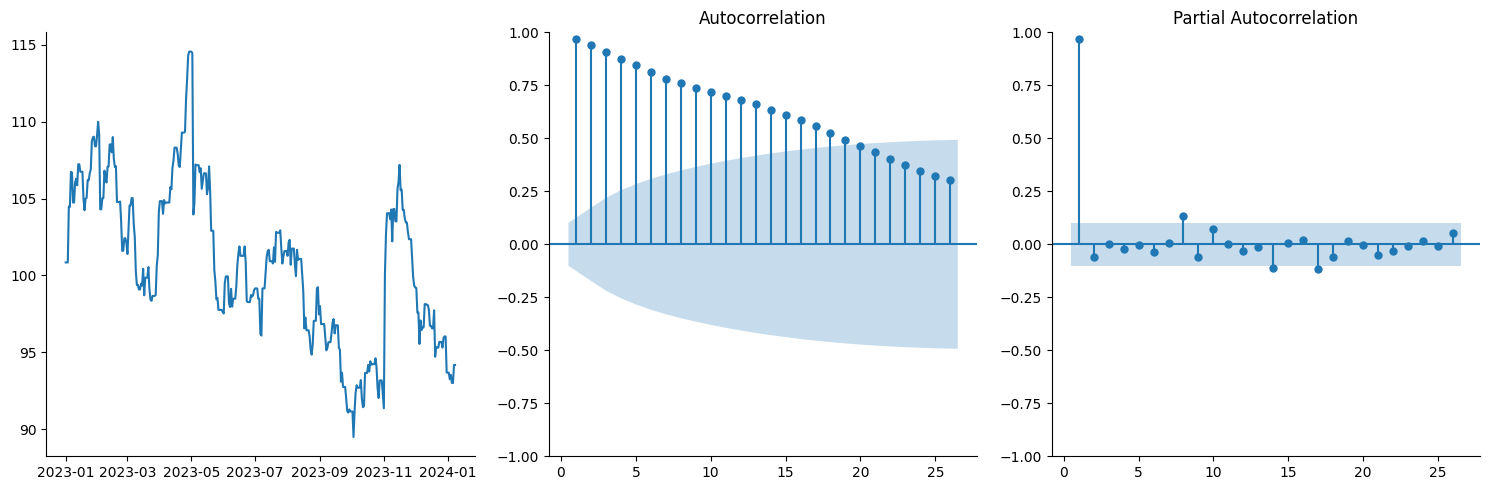

In [16]:
plots(df_new2)

From the PACF, it is clear that there is a lag-1 correlation, while the ACF shows that we probably need differencing, possibly multiple times, to ensure stationarity.

We start with testing the time series with a Dickey-Fuller test for stationarity.

In [17]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_new2.close)

print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -2.0915064868361855
p-value: 0.24794357284686325


We cannot reject the null hypothesis, hence the series is not stationary. We can check that mean and variance are not really constant, for example.

In [18]:
# split data into chunks
chunks = np.split(df_new2.close[:360], indices_or_sections=15)

mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

/Users/giacomofragione/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


,mean_vals,var_vals
0,105.228750,3.575528
1,107.470000,2.567008
2,102.766667,4.761806
3,100.947500,6.064560
4,108.535000,9.032200
5,105.999583,10.949229
6,98.980833,1.643066
7,99.122083,1.977483
8,101.652083,0.531141
9,98.607083,5.865096


The series seems not to have clear signs of seasonality, so we proceed with checking if the series becomes more stationary with differencing. From the previous plots, we found that there is a lag-1 auto-correlation, so we use this lag in our differencing.

In [19]:
df_new2['close_lag1'] = df_new2['close'].diff(1)

In [20]:
df_new2.close_lag1.fillna(0, inplace=True)

In [21]:
df_new2.close_lag1.head()

2023-01-01    0.00
2023-01-02    0.00
2023-01-03    0.00
2023-01-04    3.64
2023-01-05   -0.03
Freq: D, Name: close_lag1, dtype: float64

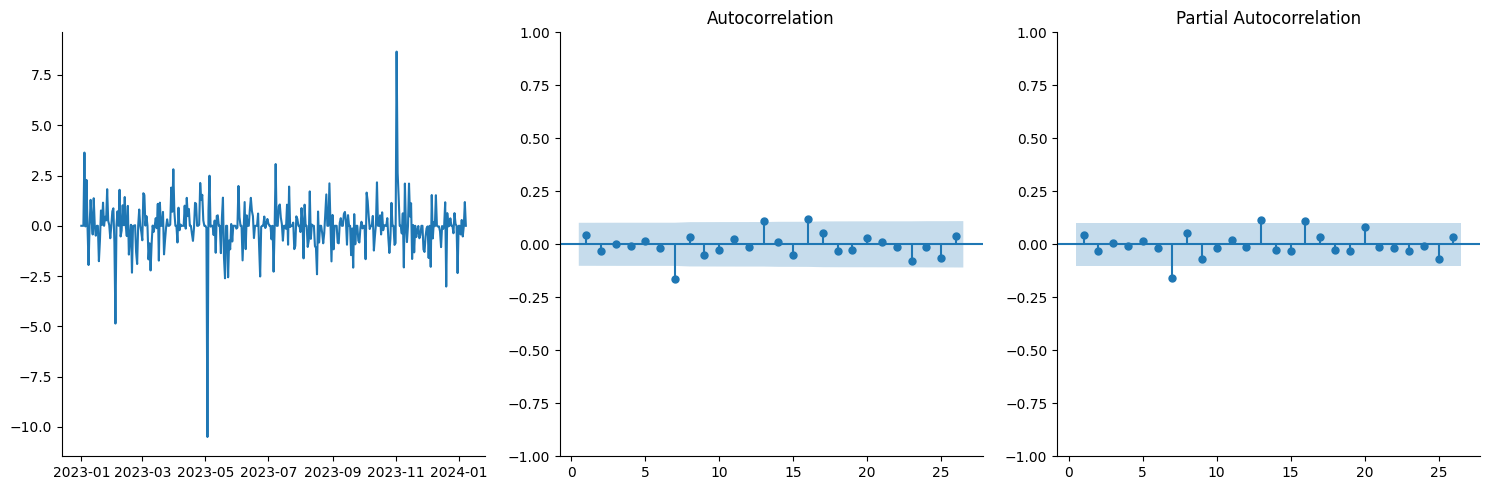

In [22]:
plots(df_new2.close_lag1)

In [23]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_new2.close_lag1)

print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -8.680440368610505
p-value: 4.3005950961713495e-14


After performing an ADF test, it seems that we reject the null hypothesis and say that the series is likely stationary. From the left panle of the previous plot, it also seems that the series is likely close to homoscedasticity.

From previous plots, it seems that we can run an ARIMA model, with p=1, d=1, q=0, and no seasonality. We assume a constant trend.

## 2. ARIMA models

In [30]:
sar = SARIMAX(df_new2.close, order=(1,1,0), seasonal_order=(0,0,0,0), trend='c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59373D+00    |proj g|=  2.24481D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      5      1     0     0   9.270D-06   1.594D+00
  F =   1.5937313409790343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


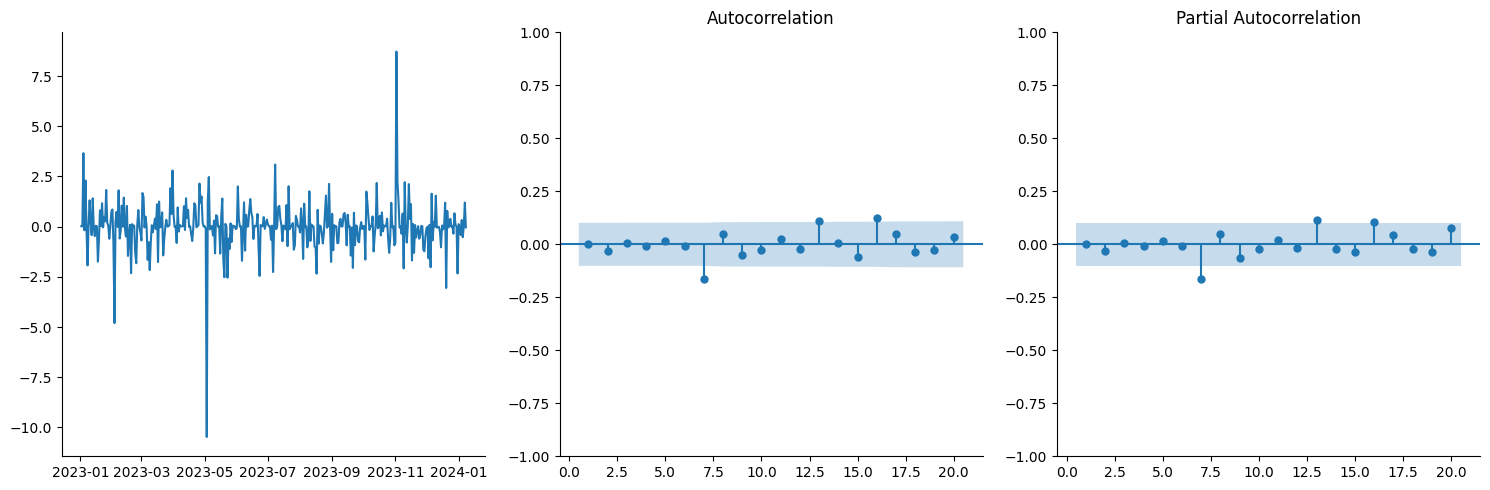

In [31]:
plots(sar.resid[sar.loglikelihood_burn:], lags=20)

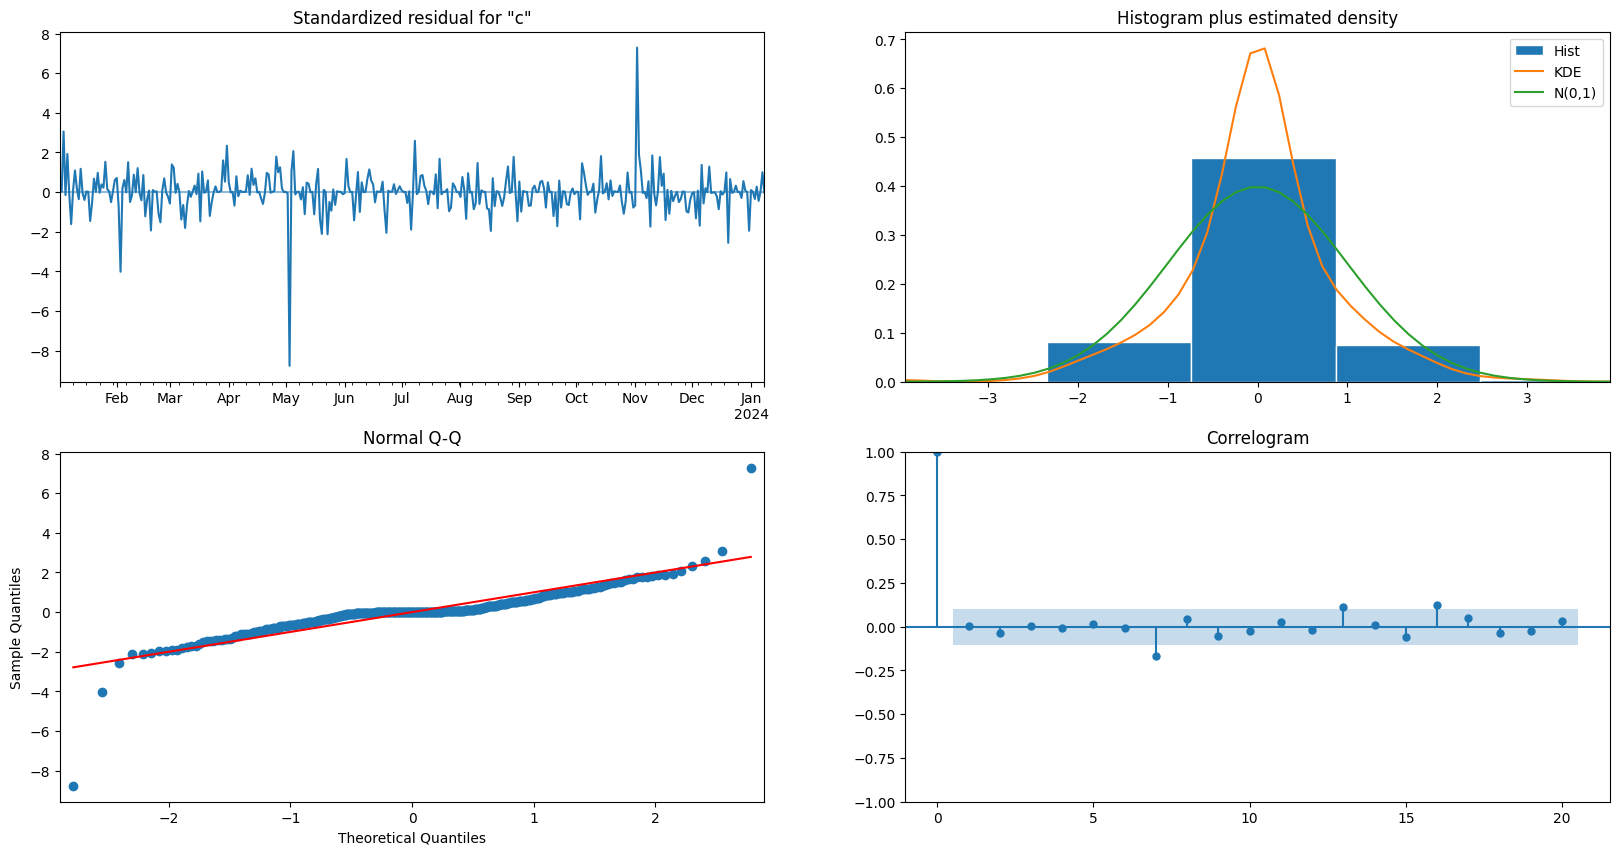

In [32]:
sar.plot_diagnostics(figsize = (20,10), lags=20);

From the diagnostic plots, it seems that we are probably doing a good job, but we can scan the parameter space around what we started with to ensure that we have the models with the smallest precitive errors.

We first define a few useful functions.

In [33]:
def grid_search_ARIMA(series,horizon,start,step_size,orders = [(1,0,0)],seasonal_orders = [(0,0,0,0)],trends=[None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)

#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (series): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = SARIMAX(series[:i+1], #only using data through to and including start 
                        order=order, 
                        seasonal_order=seasonal_order, 
                        trend=trend).fit(disp=0)
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [35]:
import warnings
warnings.filterwarnings('ignore')

series = df_new2.close
horizon = 1
start = int(len(df_new2.close) * 0.9)
step_size = 1
orders = [(1,1,0),(1,1,1),(2,1,0),(2,1,1),(3,1,0),(3,1,1)]
seasonal_orders = [(0,0,0,0)]
trends = [None,'c','t']

best_order,best_seasonal_order, best_trend, best_mape = grid_search_ARIMA(series = series,
                                                              horizon = horizon,
                                                              start = start,
                                                              step_size = step_size,
                                                              orders = orders,
                                                              seasonal_orders = seasonal_orders,
                                                              trends=trends)

In [36]:
# best parameters for ARIMA models according to our metric

best_order,best_seasonal_order, best_trend, best_mape

((1, 1, 0), (0, 0, 0, 0), None, 0.005984688929437033)

We now build the best-fit ARIMA model according to our metric and use it to forecast.

In [41]:
sar_best = SARIMAX(df_new2.close, order=(1,1,0), seasonal_order=(0,0,0,0), trend=None).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59384D+00    |proj g|=  2.24505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   9.495D-06   1.594D+00
  F =   1.5938332771032193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


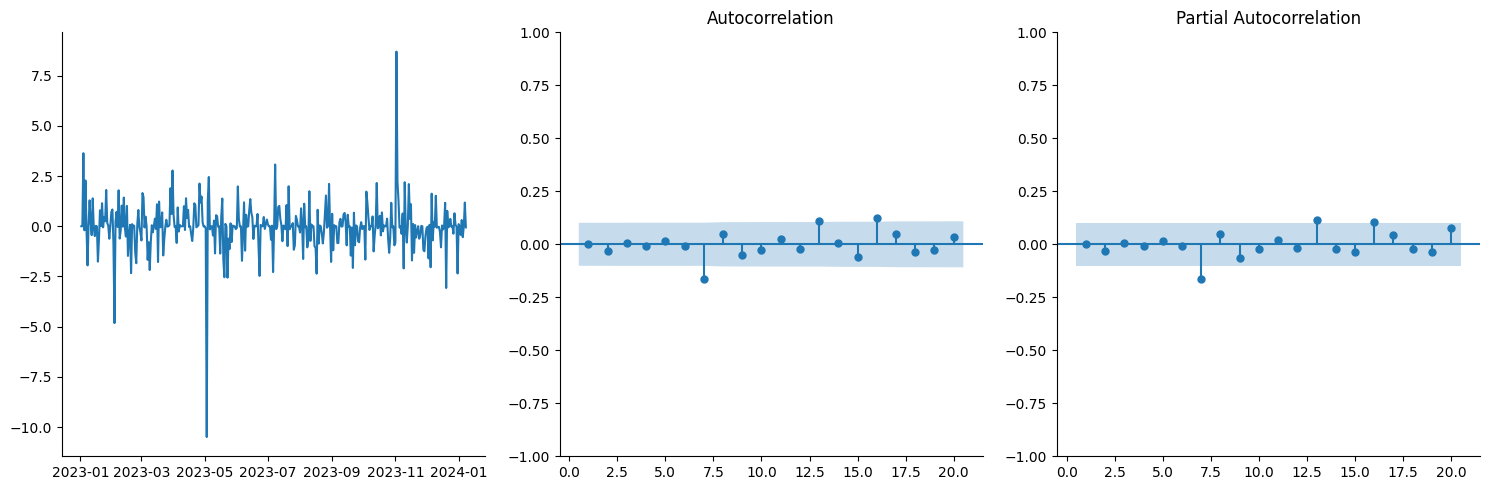

In [42]:
plots(sar_best.resid[sar_best.loglikelihood_burn:], lags=20)

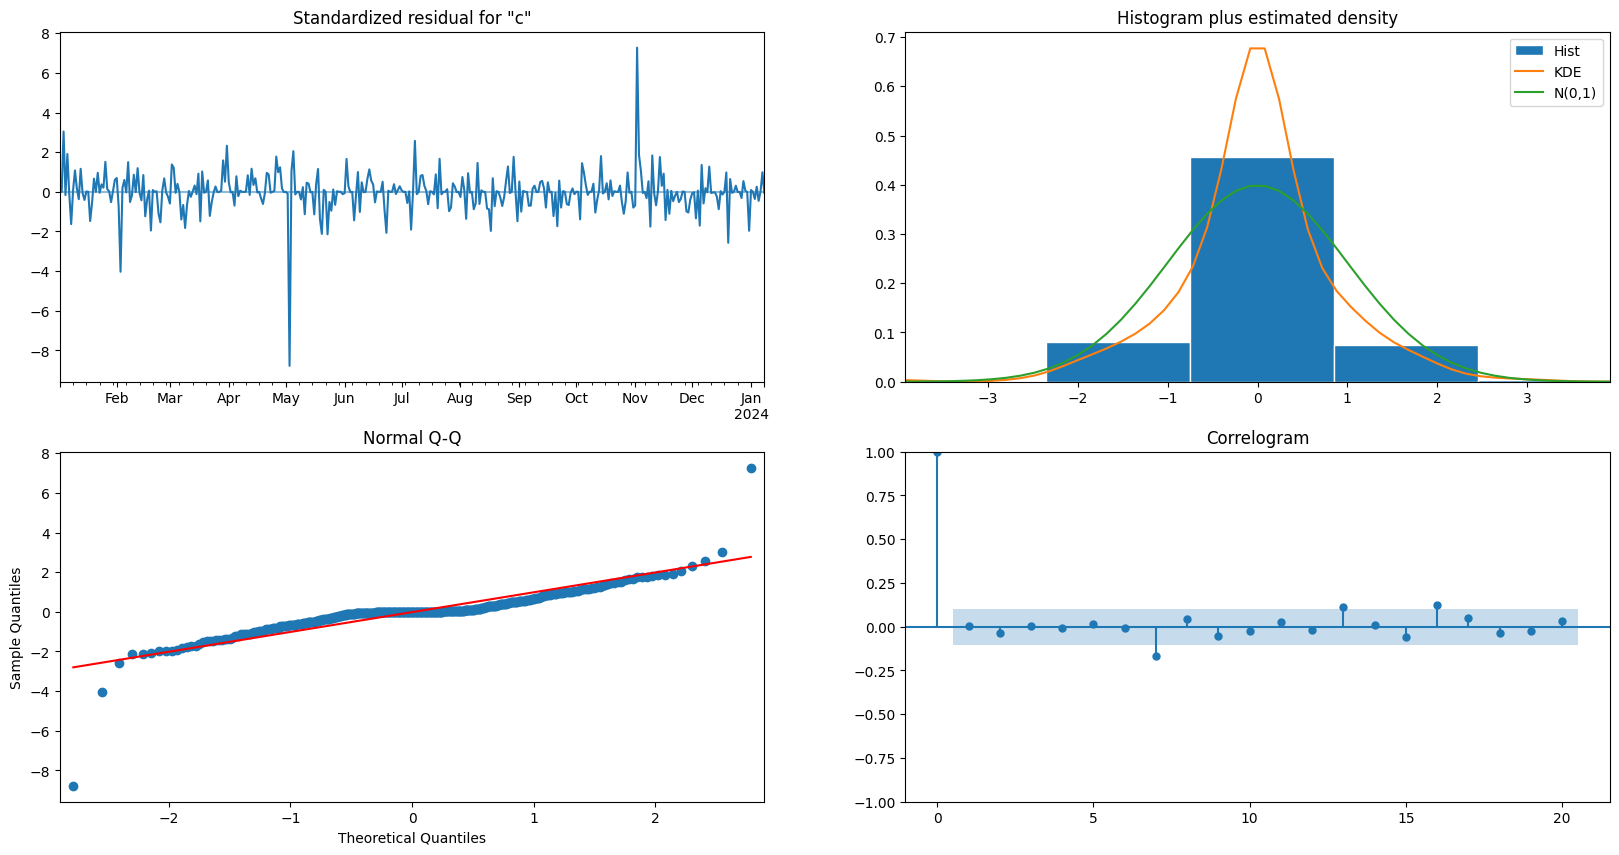

In [43]:
sar_best.plot_diagnostics(figsize = (20,10), lags=20);

We also check for statistical tests on our best model to understand if we are doing a good job or not.

In [44]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar_best.test_normality('jarquebera')[0]
lb_val, lb_p = sar_best.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar_best.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar_best.filter_results.standardized_forecasts_error[0, sar_best.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=8102.618, p=0.000
Ljung-Box: val=13.024, p=0.222
Heteroskedasticity: val=0.682, p=0.034
Durbin-Watson: d=2.00


Apart from the normality test on the residuals, it seems that the other tests are passed. For the moment, this is probably sufficient and we proceed with checking our prediction and forecast.

## 3. Forecast

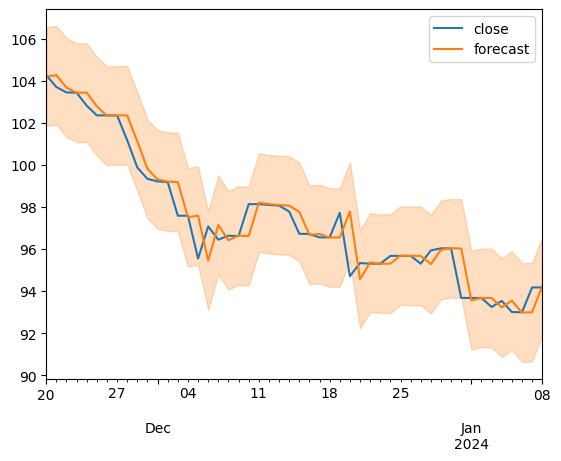

In [45]:
# plot predictions
pd.plotting.register_matplotlib_converters()

start, end = len(df_new2.close) - 50, len(df_new2.close)

predic = sar_best.get_prediction(start = start, end= end)
confidence_int = predic.conf_int(alpha = 0.05)

df_new2['forecast'] = predic.predicted_mean
df_new2[start:end][['close', 'forecast']].plot()

plt.fill_between(confidence_int.index,confidence_int['lower close'],confidence_int['upper close'],alpha = 0.25, color='C1');

In our last plot, we give our forecast for the next five days with the 90% probability interval.

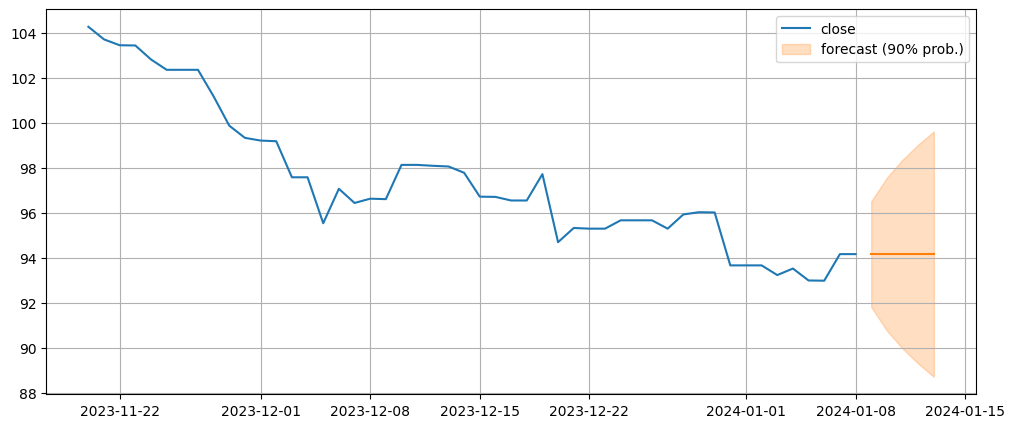

In [46]:
plt.figure(figsize=(12,5))

future_fcst = sar_best.get_forecast(5)
fcst = future_fcst.predicted_mean
confidence_int = future_fcst.conf_int(alpha = 0.05) # 90% confidence

plt.plot(df_new2.close[start:end], label='close')
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower close'],confidence_int['upper close'],alpha = 0.25, color='C1', label='forecast (90% prob.)')
plt.legend()
plt.grid()